### 一、数据集介绍
movies_metadata： budget, genres, homepage, imdb_id, original_language, original_title（电影名称）, overview, popularity（在 Movie Database 上的相对页面查看次数）, production_companies, production_countries, release_date, revenue, runtime（电影时长）, spoken_language, tagline, title, video, vote_average, vote_count,cast,director,tagline,keywords,release_year(发行年份),budget_adj：根据通货膨胀调整的预算（2010 年，美元）,revenue_adj：根据通货膨胀调整的收入（2010 年，美元）

credits：cast, crew, movie_id, title

### 二、提出问题
1. 电影类型如何随时间变化？ 电影数量上的对比 电影收入的对比
2. 影响电影收入的客观因素有哪些？
3. 两家电影公司Universal Pictures 和 Paramount Pictures之间的对比。 电影发行数量上的对比 电影产生的利润对比
4. 改编电影和原创电影之间的对比。 电影发行数量上的对比 电影产生的利润对比

### 三、导入数据

#### 1. 导入模块

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#### 2.导入数据

In [2]:
movies = pd.read_csv('tmdb_5000_movies.csv', parse_dates=['release_date'], encoding='utf-8')
credits = pd.read_csv('tmdb_5000_credits.csv', encoding='utf-8')
print('movies:', movies.shape, 'credits:', credits.shape)

movies: (4803, 20) credits: (4803, 4)


#### 3.合并数据

In [3]:
del credits['title']
full = pd.concat([credits, movies], axis=1)
print('合并后数据集:', full.shape)

合并后数据集: (4803, 23)


### 四、数据清洗

#### 1. 选择子集

In [4]:
#选择子集，选择与问题相关的特征数据
full=full[['id','title','vote_average','production_companies','genres',
     'release_date','keywords','runtime','budget','revenue','vote_count','popularity']]
#查看数据集信息
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 12 columns):
id                      4803 non-null int64
title                   4803 non-null object
vote_average            4803 non-null float64
production_companies    4803 non-null object
genres                  4803 non-null object
release_date            4802 non-null datetime64[ns]
keywords                4803 non-null object
runtime                 4801 non-null float64
budget                  4803 non-null int64
revenue                 4803 non-null int64
vote_count              4803 non-null int64
popularity              4803 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(4), object(4)
memory usage: 450.4+ KB


#### 2.处理缺失值

In [5]:
# release_date 缺失一条数据，先将其找到
full.loc[full['release_date'].isnull(),'title']

4553    America Is Still the Place
Name: title, dtype: object

In [6]:
#上网查到缺失电影首次上映日期为2014-06-01，填充缺失值
full['release_date']=full['release_date'].fillna('2014-06-01')
full.loc[4553, 'release_date']

'2014-06-01'

In [7]:
#runtime缺失两条数据，数值型可用平均数填充
full['runtime']=full['runtime'].fillna(full['runtime'].mean())

#### 3.数据类型转换

In [8]:
#release_date转换为年月日，并提取年份
full['release_year']=pd.to_datetime(full['release_date'], format='%Y-%m-%d').dt.year
full['release_year'].head()

0    2009
1    2007
2    2015
3    2012
4    2012
Name: release_year, dtype: int64

In [9]:
#json格式转换为字典
def getname(x):
    a=[]
    for i in x:
        a.append(i['name'])
    return ','.join(a)
#genres 风格
full['genres']=full['genres'].apply(json.loads)
full['genres']=full['genres'].apply(getname)

# production_companies 制作公司
full['production_companies']=full['production_companies'].apply(json.loads)
full['production_companies']=full['production_companies'].apply(getname)

# keywords 与电影相关的关键字
full['keywords']=full['keywords'].apply(json.loads)
full['keywords']=full['keywords'].apply(getname)

### 五、问题分析

#### 1. 电影类型随时间变化

In [10]:
#提取电影类型
genresList=set()
for s in full['genres'].str.split(','):
    genresList=set(s).union(genresList)
genresList=list(genresList)
genresList.remove('')
genresList

['Horror',
 'Action',
 'Thriller',
 'History',
 'Comedy',
 'Animation',
 'Romance',
 'TV Movie',
 'Fantasy',
 'Mystery',
 'Documentary',
 'Crime',
 'Music',
 'Drama',
 'Adventure',
 'Science Fiction',
 'Western',
 'Foreign',
 'War',
 'Family']

In [11]:
#将电影类型添加到列，进行one-hot编码
genresDf=pd.DataFrame()
for genre in genresList:
    genresDf[genre]=full['genres'].str.contains(genre).apply(lambda x:1 if x else 0)

In [12]:
#改用年份索引
genresDf['release_year']=full['release_year']
genresDf.set_index('release_year',inplace=True)
genresDf=genresDf.sort_index()

In [13]:
#对每个类型的电影按年份求和
genresDf=genresDf.groupby('release_year').sum()

In [14]:
#汇总各电影类型的总量
total=genresDf.sum().sort_values()

In [15]:
#选出数量最多的十类电影
total=total[-10:]
total

Family              513
Horror              519
Science Fiction     535
Crime               696
Adventure           790
Romance             894
Action             1154
Thriller           1274
Comedy             1722
Drama              2297
dtype: int64

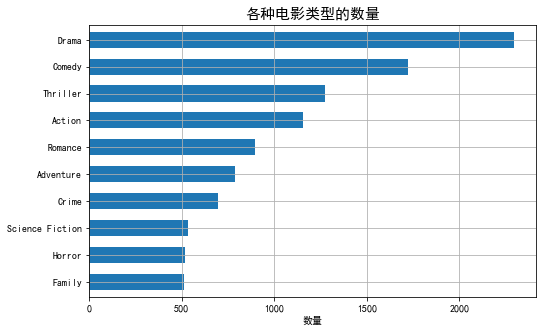

In [16]:
#数量最多的10大类型电影
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
total.plot(kind='barh', figsize=(8,5),width=0.6)
plt.title('各种电影类型的数量',fontsize=15)
plt.xlabel('数量',fontsize=10)
plt.grid(True)
plt.show()

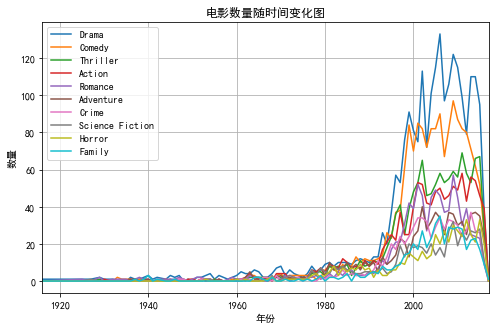

In [17]:
#电影类型随时间变化
genresDf=genresDf[['Drama','Comedy','Thriller','Action','Romance','Adventure',
                   'Crime','Science Fiction','Horror','Family']]
genresDf.plot(figsize=(8,5))
plt.title('电影数量随时间变化图')
plt.xlabel('年份')
plt.ylabel('数量')
plt.grid(True)
plt.show()

从上图可以看出，所有类型的电影在1960年前几乎没什么变化，从1960-1990开始缓慢增长，此后呈现急剧增长，其中戏剧（Drama）增长最快，数量最多，喜剧（Comedy）次之，到近代恐怖片（Thriller）数量超过喜剧，动作片（Action）接近恐怖片。这四类电影都可作为投资的首选。

#### 2. 影响电影收入的客观因素有哪些？

In [18]:
#电影收入的相关矩阵
corrDf=full.corr()
corrDf['revenue'].sort_values(ascending=False) #相关程度按降序排列

revenue         1.000000
vote_count      0.781487
budget          0.730823
popularity      0.644724
runtime         0.251080
vote_average    0.197150
release_year    0.090084
id             -0.050425
Name: revenue, dtype: float64

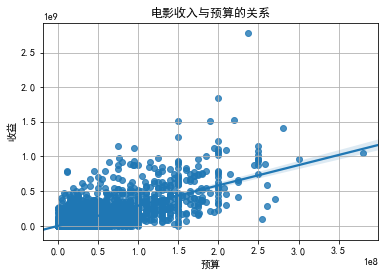

In [19]:
#电影收入与预算的关系
sns.regplot(full['budget'],full['revenue']) #seaborn中regplot函数用于绘制双变量线性回归曲线
plt.title('电影收入与预算的关系')
plt.xlabel('预算')
plt.ylabel('收益')
plt.grid(True)
plt.show()

可以看出，电影收入与评分次数、预算、电影页面相对查看次数的相关性较高。
电影收入和预算的相关性曲线是正线性相关，所以，保证一定的电影预算是提高电影收入的重要基础。

#### 3. Universal Pictures和Paramount Pictures之间的对比

##### 3.1 电影发行量对比

In [20]:
#电影发行总量对比
full['Universal Pictures']=full['production_companies'].str.contains('Universal Pictures').apply(lambda x:1 if x else 0)
full['Paramount Pictures']=full['production_companies'].str.contains('Paramount Pictures').apply(lambda x:1 if x else 0)
Universal_total=full['Universal Pictures'].sum()
Paramount_total=full['Paramount Pictures'].sum()
total_all=pd.Series({'Universal Pictures':Universal_total,
                    'Paramount Pictures':Paramount_total})
total_all

Universal Pictures    314
Paramount Pictures    285
dtype: int64

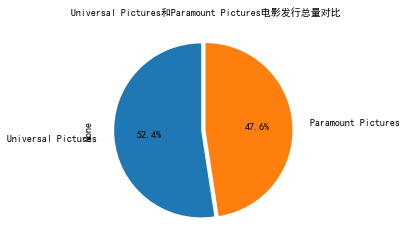

In [21]:
total_all.plot(kind='pie',autopct='%1.1f%%',explode=(0.05,0),
              startangle=90,labeldistance=1.2,shadow=False)
plt.title('Universal Pictures和Paramount Pictures电影发行总量对比',fontsize=10)
plt.show()

In [27]:
#利润=收入-预算
full['profit']=full['revenue']-full['budget']
full['Universal_profit']=full['Universal Pictures']*full['profit']
full['Paramount_profit']=full['Paramount Pictures']*full['profit']

In [28]:
#电影发行量变化对比
companyDf=full[['release_year','Universal Pictures','Paramount Pictures','Universal_profit',
              'Paramount_profit']]
companyDf.set_index('release_year',inplace=True)
companyDf=companyDf.sort_index()
companyDf=companyDf.groupby('release_year').sum()

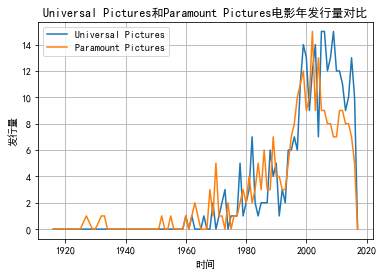

In [32]:
#可视化
plt.plot(companyDf.index,companyDf['Universal Pictures'],label='Universal Pictures')
plt.plot(companyDf.index,companyDf['Paramount Pictures'],label='Paramount Pictures')
plt.xlabel('时间')
plt.ylabel('发行量')
plt.title('Universal Pictures和Paramount Pictures电影年发行量对比')
plt.grid(True)
plt.legend()
plt.show()

从电影发行总量上看，Universal Pictures公司比Paramount Pictures公司多；
从电影年发行量随时间的变化来看，两家制作公司基本都是在增长，但Universal Pictures公司在近期增长更平稳。

##### 3.2 利润对比

In [35]:
#总利润对比
Universal_profit=full['Universal_profit'].sum()
Paramount_profit=full['Paramount_profit'].sum()
profit_total=pd.Series({'Universal_profit':Universal_profit,
                        'Paramount_profit':Paramount_profit})
profit_total

Universal_profit    28990348596
Paramount_profit    27568910158
dtype: int64

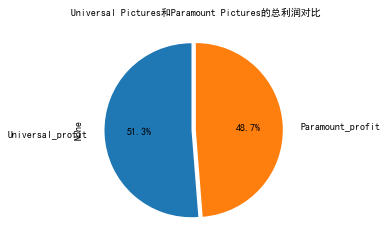

In [38]:
#可视化
profit_total.plot(kind='pie',autopct='%1.1f%%',explode=(0.05,0),
                 startangle=90,labeldistance=1.2,shadow=False)
plt.title('Universal Pictures和Paramount Pictures的总利润对比',fontsize=10)
plt.show()

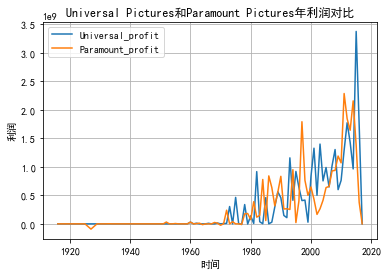

In [42]:
#年利润对比可视化
plt.plot(companyDf.index,companyDf['Universal_profit'],label='Universal_profit')
plt.plot(companyDf.index,companyDf['Paramount_profit'],label='Paramount_profit')
plt.xlabel('时间')
plt.ylabel('利润')
plt.title('Universal Pictures和Paramount Pictures年利润对比')
plt.grid(True)
plt.legend()
plt.show()

两家制作公司的利润对比，总利润Universal Pictures公司多于Paramount Pictures公司；
从年利润上看，两家公司利润都随时间增长，其中Universal_profit公司增长较平稳，且最近几年增长最快。

#### 4. 改编电影和原创电影的对比

##### 4.1 数量对比

In [43]:
#原创电影和改编电3影分类
full['if_original']=full['keywords'].str.contains('based on novel').apply(lambda x:'not original' if x else 'original')

In [44]:
#两种类型数量汇总信息
key_count=full['if_original'].value_counts()
key_count

original        4606
not original     197
Name: if_original, dtype: int64

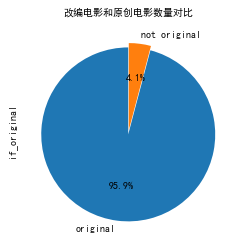

In [45]:
#可视化
key_count.plot(kind='pie',autopct='%1.1f%%',explode=(0.05,0),
               startangle=90,labeldistance=1.1,shadow=False)
plt.title('改编电影和原创电影数量对比',fontsize=10)
plt.show()

##### 4.2 改编电影和原创电影平均利润对比

In [48]:
#原创电影和改编电影的平均利润
original_total=full.groupby('if_original')['profit'].mean()
original_total

if_original
not original    9.848457e+07
original        5.127943e+07
Name: profit, dtype: float64

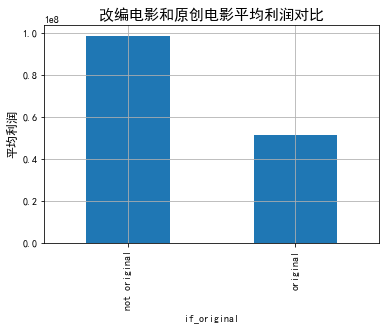

In [49]:
#可视化
original_total.plot(kind='bar')
plt.title('改编电影和原创电影平均利润对比',fontsize=15)
plt.ylabel('平均利润',fontsize=12)
plt.grid(True)
plt.show()

从以上两幅可视化图片可以看出，原创电影的发行数量远远多于改编电影；
但改编电影的平均利润却是原创电影的近两倍；说明原创电影虽然是主流电影，但好的小说改编电影却能带来更多的利润。
所以，如果有较好的小说剧本，可以尝试制作改编电影，可以带来更多的收益。